<a href="https://colab.research.google.com/github/CSID-DGU/2021-1-OSSP1-Debugger-4/blob/face-recognization/image_merge_version1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


146 165 138


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:175: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:177: RuntimeWarning: overflow encountered in ubyte_scalars


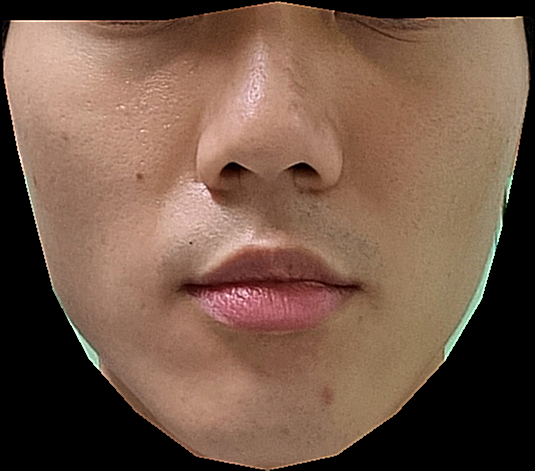

19.595711461156114
17.99530166910273


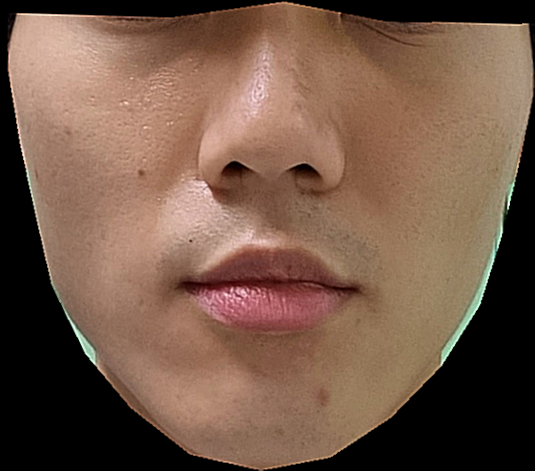

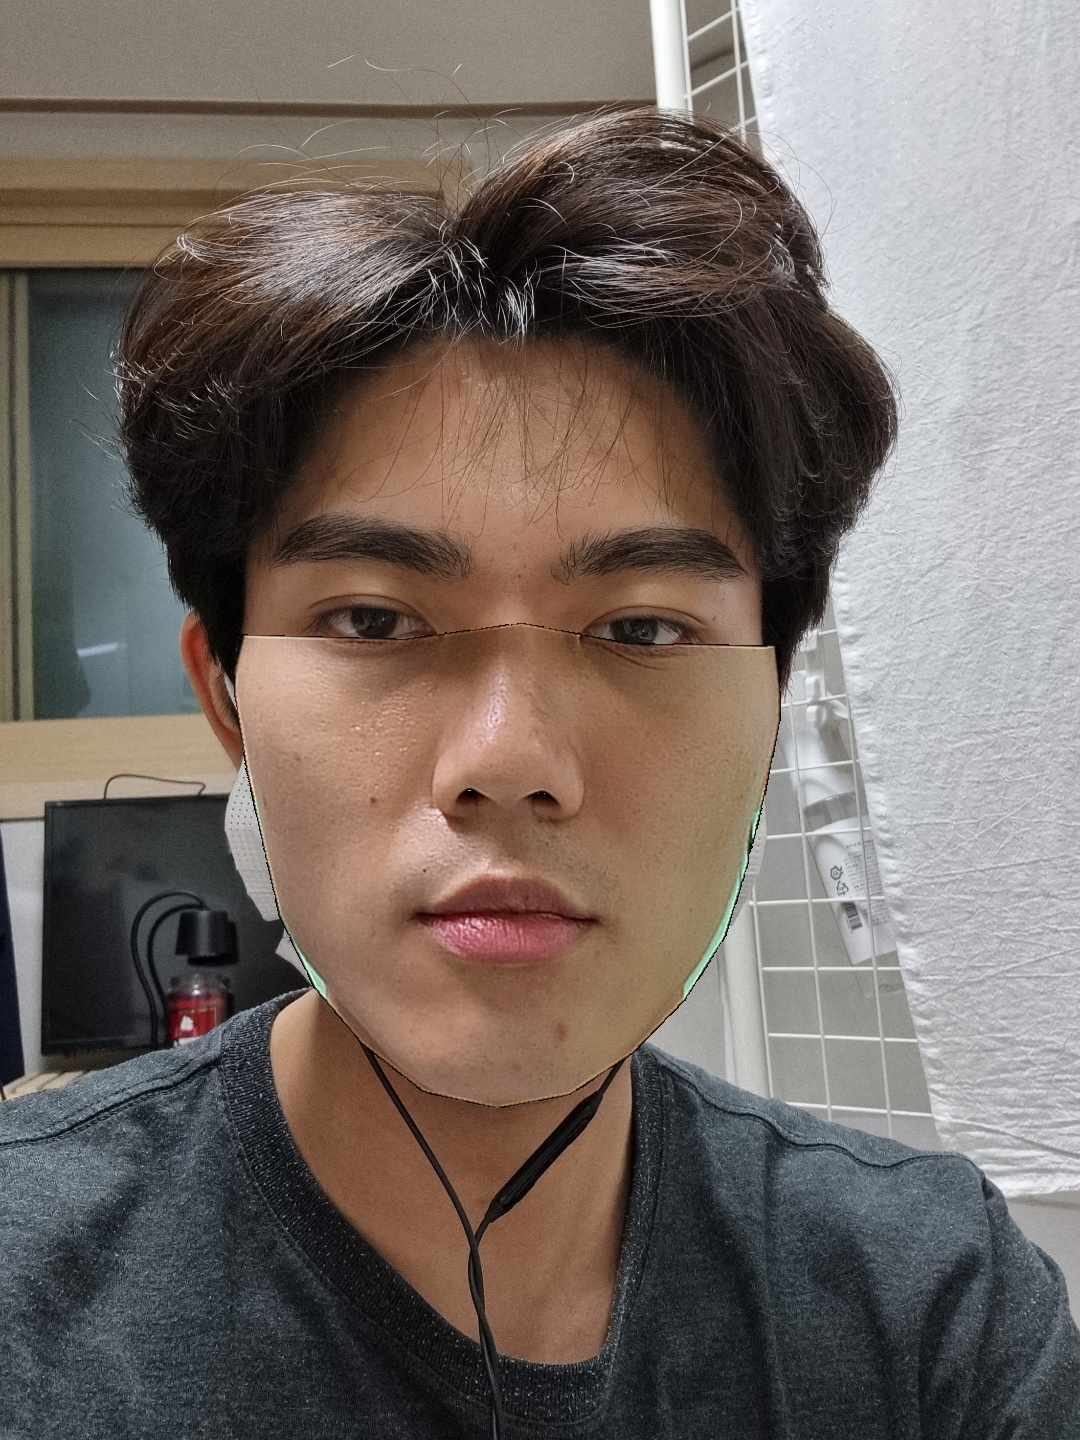

In [13]:
from imutils import face_utils
from google.colab.patches import cv2_imshow
import numpy as np
import imutils
import dlib
import cv2
import math

dx = 0
# 얼굴 Detection 및 Landmark 생성
def faceDetection(img, detector, predictor):
  #h, w, ch = img.shape
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects = detector(gray,1)
  roi = rects[0]
  shape = predictor(gray, roi)
  shape = face_utils.shape_to_np(shape)
  return shape


#마스크부분 추출
def extractMask(landmark, img):
  h, w, ch = img.shape
  # extract jawline
  jawline = landmark[0:17]
  lefteye = landmark[36:42]
  righteye = landmark[42:48]

  nose = landmark[27][1]

  top = nose
  bottom = max(jawline[:,1])
  side1 = min(jawline[:,0])
  side2 = max(jawline[:,0])
  side = side2-side1

  lefteyeline = max(lefteye[:,1])
  righteyeline = max(righteye[:,1])

  # extend contour for masking
  jawline = np.append(jawline, [ w-1, landmark[42][1]]).reshape(-1, 2)
  jawline = np.append(jawline, [landmark[47][0],landmark[47][1]]).reshape(-1,2)
  jawline = np.append(jawline, [landmark[27][0],landmark[27][1]]).reshape(-1,2)
  #jawline = np.append(jawline, [landmark[40][0],landmark[40][1]]).reshape(-1,2)
  #jawline = np.append(jawline, [ 0, landmark[40][1] ]).reshape(-1, 2)
  jawline = np.append(jawline, [ w-1, nose]).reshape(-1,2)
  jawline = np.append(jawline, [ w-1, h-1 ]).reshape(-1, 2)
  jawline = np.append(jawline, [ 0, h-1 ]).reshape(-1, 2)
  jawline = np.append(jawline, [0, nose]).reshape(-1,2)
  jawline = np.append(jawline, [landmark[27][0],landmark[27][1]]).reshape(-1,2)
  jawline = np.append(jawline, [landmark[40][0],landmark[40][1]]).reshape(-1,2)
  jawline = np.append(jawline, [ 0, landmark[40][1] ]).reshape(-1, 2)
  contours = [jawline]

  # generate mask
  mask = np.ones((h,w,1), np.uint8) * 255 # times 255 to make mask 'showable'
  b,g,r = img[27][0]
  print(b,g,r)
  cv2.drawContours(mask, contours, -1, 0, -1) # remove below jawline
  # apply to image
  result = cv2.bitwise_and(img, img, mask = mask)
  result = result[nose:bottom, side1:side2] # crop ROI

  #bluring
  #low_pass_filter_3x3 = np.ones((3, 3), np.float32) / 9.0
  #result = cv2.filter2D(result, -1, low_pass_filter_3x3)


  #sharpening
  sharpening_2 = np.array([[-1, -1, -1, -1, -1],
                         [-1, 2, 2, 2, -1],
                         [-1, 2, 9, 2, -1],
                         [-1, 2, 2, 2, -1],
                         [-1, -1, -1, -1, -1]]) / 9.0
  result = cv2.filter2D(result, -1, sharpening_2)
  
  return result

'''
# 사람 피부색 영역에 해당하는 마스크를 통해 두 사진에서 얼굴의 색 평균값 추출 이후, 해당 값의 차이만큼 bgr 조정
def coloring(img1, img2):
    img1_ycrcb = cv2.cvtColor(img1, cv2.COLOR_BGR2YCrCb)
    img2_ycrcb = cv2.cvtColor(img2, cv2.COLOR_BGR2YCrCb)
    lower = np.array([0,133,77], dtype = np.uint8)
    upper = np.array([255,173,127], dtype = np.uint8)
    mask1 = cv2.inRange(img1_ycrcb, lower, upper)
    mask2 = cv2.inRange(img2_ycrcb, lower, upper)
    skin1 = cv2.bitwise_and(img1, img1, mask = mask1)
    skin2 = cv2.bitwise_and(img2, img2, mask = mask2)
    #cv2_imshow(skin1)
    #cv2_imshow(skin2)
    height1, width1, channel1 = skin1.shape
    tmp = 0
    black = 0
    b1 = 0
    g1 = 0
    r1 = 0
    
    for y in range(0, height1):
        for x in range(0, width1):
            b = skin1.item(y,x,0)
            g = skin1.item(y,x,1)
            r = skin1.item(y,x,2)
            
            if(b==0 and g==0 and r== 0):
                black +=1
            else:
                tmp +=1
            b1 = b1 + b
            g1 = g1 + g
            r1 = r1 +r

    height2, width2, channel2 = skin2.shape
    tmp2 = 0
    b2 = 0
    g2 = 0
    r2 = 0
    
    for y in range(0, height2):
        for x in range(0, width2):
            b = skin2.item(y,x,0)
            g = skin2.item(y,x,1)
            r = skin2.item(y,x,2)
            
            if(b==0 or g==0 or r== 0):
                black +=1
            else:
                tmp2  +=1
            b2 = b2 + b
            g2 = g2 + g
            r2 = r2 + r
     
    red =  r2/tmp2 -r1/tmp
    green = g2/tmp2 - g1/tmp
    blue = b2/tmp2 - b1/tmp
   
    val = min(abs(red), abs(green), abs(blue))
    if(val == -red or val == -blue or val == -green):
        val = val * -1

    if(val>0):    
      array = np.full(img1.shape, (val, val, val), dtype = np.uint8)
      img1 = cv2.add(img1, array)
    else:
      array = np.full(img1.shape, (-val, -val, -val), dtype = np.uint8)
      img1 = cv2.subtract(img1, array)
    return img1
'''

def coloring(img, img2, landmark_1, landmark_2):
  x1_img1 = int(landmark_1[0][0] + landmark_1[36][0] / 2)
  y1_img1 = landmark_1[36][1]
  x1_img2 = int(landmark_2[0][0] + landmark_2[36][0] / 2)
  y1_img2 = landmark_2[36][1]

  x2_img1 = int((landmark_1[39][0] + landmark_1[27][0]) / 2)
  y2_img1 = landmark_1[27][1]
  x2_img2 = int((landmark_2[39][0] + landmark_2[27][0]) / 2)
  y2_img2 = landmark_2[27][1]

  x3_img1 = int((landmark_1[27][0] + landmark_1[42][0]) / 2)
  y3_img1 = landmark_1[27][1]
  x3_img2 = int((landmark_2[27][0] + landmark_2[42][0]) / 2)
  y3_img2 = landmark_2[27][1]

  x4_img1 = int((landmark_1[45][0] + landmark_1[16][0]) / 2)
  y4_img1 = landmark_1[45][1]
  x4_img2 = int((landmark_2[45][0] + landmark_2[16][0]) / 2)
  y4_img2 = landmark_2[45][1]

  b_1,g_1,r_1 = img[x1_img1][y1_img1]
  b_2,g_2,r_2 = img[x2_img1][y2_img1]
  b_3,g_3,r_3 = img[x3_img1][y3_img1]
  b_4,g_4,r_4 = img[x4_img1][y4_img1]
  b = (b_1+b_2+b_3+b_4)/12
  g = (g_1+g_2+g_3+g_4)/12
  r = (r_1+r_2+r_3+r_4)/12

  b2_1,g2_1,r2_1 = img2[x1_img2][y1_img2]
  b2_2,g2_2,r2_2 = img2[x2_img2][y2_img2]
  b2_3,g2_3,r2_3 = img2[x3_img2][y3_img2]
  b2_4,g2_4,r2_4 = img2[x4_img2][y4_img2]
  b2 = (b2_1+b2_2+b2_3+b2_4)/12
  g2 = (g2_1+g2_2+g2_3+g2_4)/12
  r2 = (r2_1+r2_2+r2_3+r2_4)/12

  blue = int(b-b2)
  green = int(g-g2)
  red = int(r-r2)

  val = min(abs(red), abs(green), abs(blue))
  if(val == -red or val == -blue or val == -green):
    val = val * -1
  
  if(val>0):    
    array = np.full(img2.shape, (val, val, val), dtype = np.uint8)
    img2 = cv2.add(img2, array)
  else:
    array = np.full(img2.shape, (-val, -val, -val), dtype = np.uint8)
    img2 = cv2.subtract(img2, array)
  return img2

def rotate(img,p1,p2,p3,p4):
  #x, y, c = img.shape
  #c = math.sqrt((x1**2)+(y1**2))
  #c2 = math.sqrt((x2**2)+(y2**2))

  tan1 = np.arctan2(*p1[::-1])
  tan2 = np.arctan2(*p2[::-1])
  res1 = np.rad2deg((tan1 - tan2) % (2 * np.pi))

  tan1 = np.arctan2(*p3[::-1])
  tan2 = np.arctan2(*p4[::-1])
  res2 = np.rad2deg((tan1 - tan2) % (2 * np.pi))

  print(res1)
  print(res2)
  cp = (img.shape[1]/2, img.shape[0]/2)
  rot = cv2.getRotationMatrix2D(cp, res2-res1,1)
  img = cv2.warpAffine(img, rot, (0, 0)) 
  return img
  '''
  if(c2>c):
    d = c2-c
    tan1 = np.arctan2(d, c2)
    angle = np.rad2deg(tan1) * -1/2
  else :
    d = c-c2
    tan1 = np.arctan2(d, c) 
    angle = np.rad2deg(tan1)/2
  if(angle>0):
    dx = int(d/4)
  else:
    dx = int(-d/4)
  print(dx)
  cp = (img.shape[1]/2, img.shape[0]/2)
  rot = cv2.getRotationMatrix2D(cp, angle,1)
  img = cv2.warpAffine(img, rot, (0, 0)) 
  cv2_imshow(img)
  return img
  '''
    
# 두 이미지 합하기, img_mask : 마스크부분만 자른 이미지, img : 마스크낀 이미지 landmark_1 : 마스크를 낀 사진의 landmark, landmark2 : 마스크를 안낀 사진의 landmark
def func(hpos, vpos, img_mask, img, landmark_1, landmark_2):
  x1 = landmark_1[0][0] - landmark_1[16][0]
  y1 = landmark_1[0][1] - landmark_1[16][1]
  c = math.sqrt((x1**2)+(y1**2))

  x2 = landmark_2[0][0] - landmark_2[16][0]
  y2 = landmark_2[0][1] - landmark_2[16][1]
  c2 = math.sqrt((x2**2)+(y2**2))
  size_w = c/c2

  x3 = landmark_1[27][0] - landmark_1[8][0]
  y3 = landmark_1[27][1] - landmark_1[8][1]
  c3 = math.sqrt((x3**2)+(y3**2))

  x4 = landmark_2[27][0] - landmark_2[8][0]
  y4 = landmark_2[27][1] - landmark_2[8][1]
  c4 = math.sqrt((x4**2)+(y4**2))
  size_h = c3/c4

  src = img_mask
  src = cv2.resize(src, dsize=(0,0), fx =size_w, fy= size_h, interpolation = cv2.INTER_LINEAR)
  rows, cols, channels = src.shape
  roi = img[hpos:rows+hpos,vpos:cols+vpos]

  gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
  ret, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
  #cv2_imshow(mask)
  mask_inv = cv2.bitwise_not(mask)
  #cv2_imshow(mask_inv)

  img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
  #cv2_imshow(img_bg)
  src_fg = cv2.bitwise_and(src, src, mask=mask)
  #cv2_imshow(src_fg)
  #src_fg = coloring(src_fg, img_bg)

  tmp = cv2.add(img_bg, src_fg)
  #cv2_imshow(tmp)
  img[hpos:rows+hpos, vpos:cols+vpos] = tmp
  return img


detector = dlib.get_frontal_face_detector()
pred = "./gdrive/MyDrive/opencv/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(pred)

img_path = "./gdrive/MyDrive/opencv/face8.jpg"  #마스크 낀 사진
image = cv2.imread(img_path)

img_path2 = "./gdrive/MyDrive/opencv/face6.jpg"  #마스크 안낀 사진
image2 = cv2.imread(img_path2)

landmark1 = np.empty((68,2),int)
landmark2 = np.empty((68,2),int)

landmark1 = faceDetection(image, detector, predictor)
landmark2 = faceDetection(image2, detector, predictor)

#cv2_imshow(image2)
image2 = coloring(image,image2,landmark1,landmark2)
#cv2_imshow(image2)
show_mask = extractMask(landmark2, image2)
cv2_imshow(show_mask)
show_mask = rotate(show_mask, landmark1[36],landmark1[45],landmark2[36], landmark2[45])
cv2_imshow(show_mask)

merged_img = func(landmark1[27][1],landmark1[0][0], show_mask, image, landmark1, landmark2)
cv2_imshow(merged_img)